# Time Series forecasting Energy consumption model


In [21]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
color_pal = sns.color_palette()
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [22]:

# Load the CSV file into a DataFrame
df = pd.read_csv('PJME_hourly.csv')

# Set 'Datetime' column as the index
df = df.set_index('Datetime')

# Convert the index to datetime data type
df.index = pd.to_datetime(df.index)


                     PJME_MW  hour  dayofweek  quarter  month  year  \
Datetime                                                              
2002-01-01 01:00:00  30393.0     1          1        1      1  2002   
2002-01-01 02:00:00  29265.0     2          1        1      1  2002   
2002-01-01 03:00:00  28357.0     3          1        1      1  2002   
2002-01-01 04:00:00  27899.0     4          1        1      1  2002   
2002-01-01 05:00:00  28057.0     5          1        1      1  2002   

                     dayofyear  dayofmonth  weekofyear  lag1  lag2  lag3  \
Datetime                                                                   
2002-01-01 01:00:00          1           1           1   NaN   NaN   NaN   
2002-01-01 02:00:00          1           1           1   NaN   NaN   NaN   
2002-01-01 03:00:00          1           1           1   NaN   NaN   NaN   
2002-01-01 04:00:00          1           1           1   NaN   NaN   NaN   
2002-01-01 05:00:00          1           1    

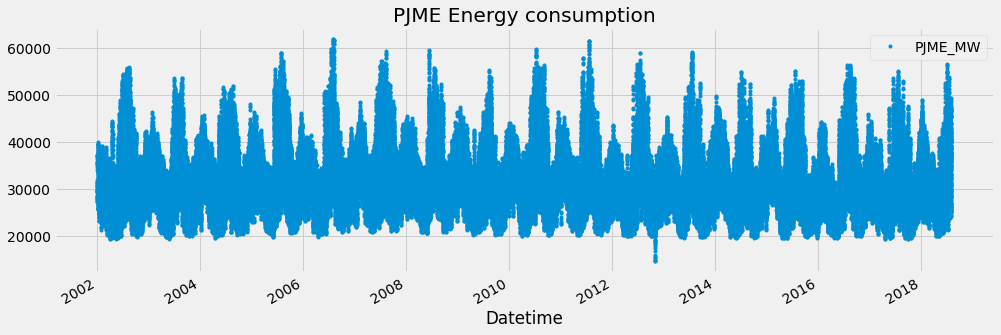

In [24]:
df.plot(style ='.', figsize = (15,5), 
        color = color_pal[0], 
        title='PJME Energy consumption')
plt.show()

# Outliers
- Outlier analysis
- forecasting horizon
- time series Cross validation
- Lag features
- Predicting the Future


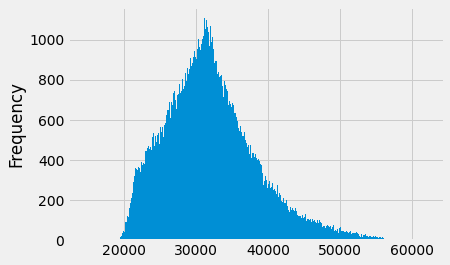

In [25]:
df['PJME_MW'].plot(kind='hist', bins=500);

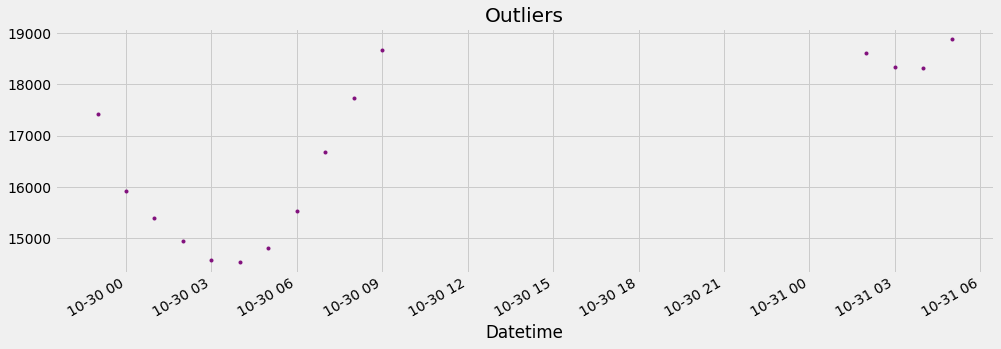

In [26]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers');

In [27]:
#df containing the query above 19,000 outlier from our data
df = df.query('PJME_MW > 19_000').copy()

# Train Test split

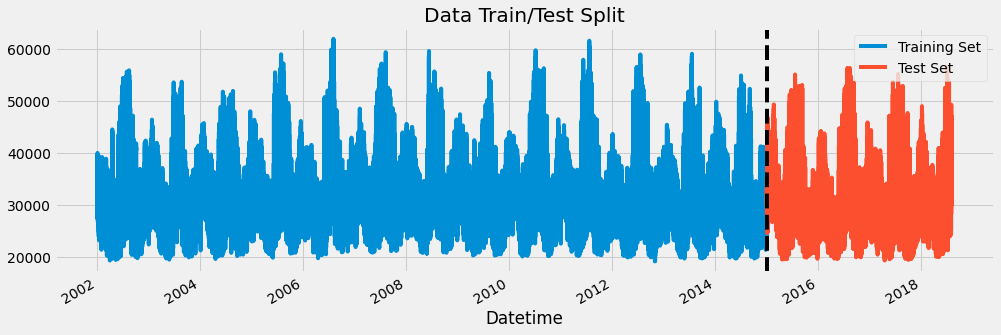

In [28]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Timeseries Validation split


In [29]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

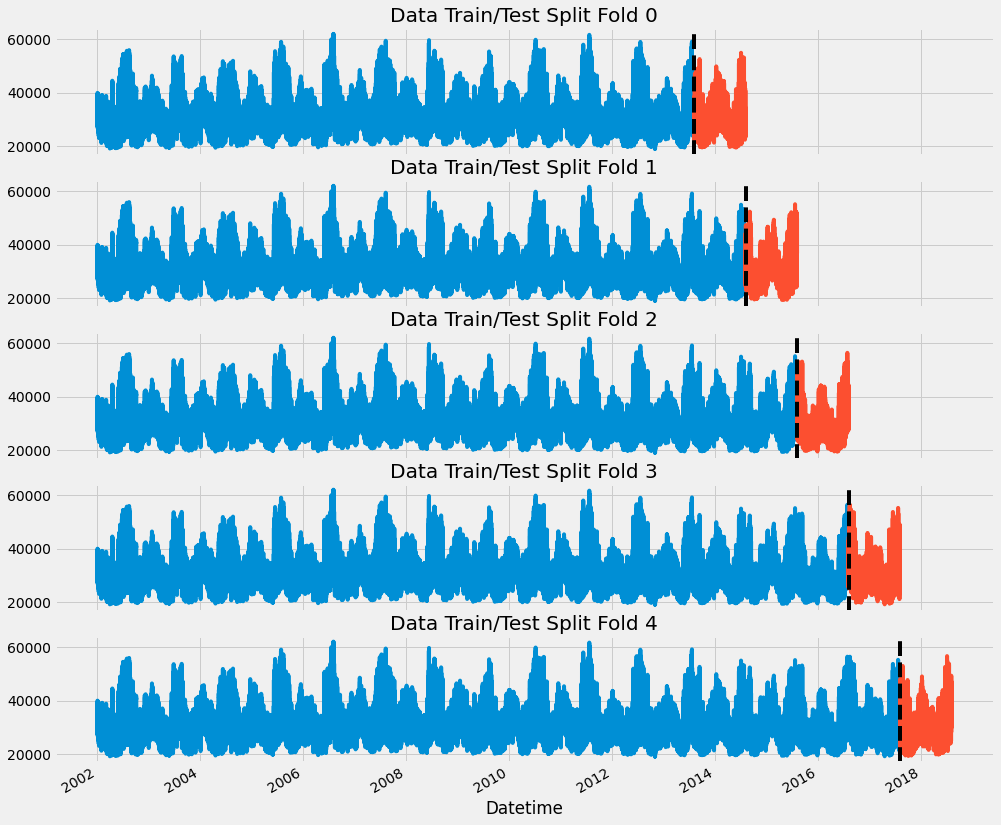

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()


# 2. Forecasting Horizon Explained
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These Generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years)

In [31]:

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag features
What was the target (x) in the past.

In [32]:
def add_lags(df):
    target_map = df ['PJME_MW'].to_dict()
    df['lag1']=(df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2']=(df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3']=(df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [33]:
df = add_lags (df)

# Train Using Cross validation


In [34]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[20:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[457]	validation_0-rmse:3348.29869	validation_1-rmse:3761.08467
[20:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rms

In [35]:
print(f'Score across folds{np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds3750.6406
Fold scores:[3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.3608331481823, 3996.298054855067]


# 4. Predicting the Future
-Retraining on all data
-to predcit the future we need an empty dataframe for future date ranges.
-Run those dates through our feature creation code + lag creation

In [36]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[20:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [37]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [51]:
#Create future dataframe
future_dates = pd.date_range(start='2018-08-03', end='2019-08-01', freq='H')
future_df = pd.DataFrame(index=future_dates)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [52]:
future_w_features = df_and_future.query('isFuture').copy()

In [53]:
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


# Predict the future

In [54]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

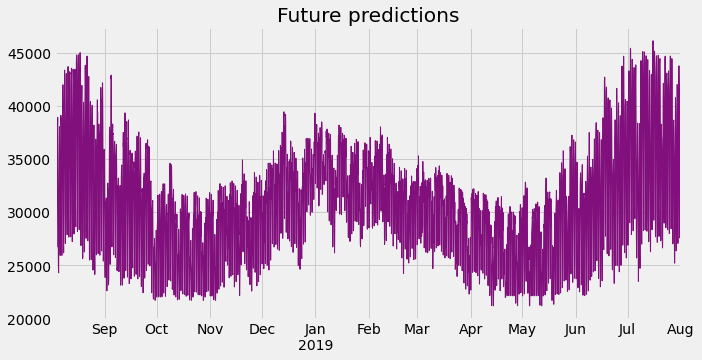

In [61]:
future_w_features['pred'].plot(figsize=(10,5),
                              color=color_pal[5],
                              ms=1,
                              lw=1,
                              title='Future predictions')
plt.show;

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [ ]:

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
df.tail()

# Visualize our Feature /Target Relationship

In [ ]:
#how to correctly setup a subplot
fig,ax = plt.subplots (figsize=(10,6))
#you can set the data on your data frame by making it a variable in this particular case data will be the where the data
# x and y axis respectebly by the name of the column always set time on the X axis
sns.boxplot(data=df, x ='hour', y= 'PJME_MW')
ax.set_title('Megawatt by hour')
plt.show()

In [ ]:
fig,ax = plt.subplots (figsize=(10,6))
sns.boxplot(data=df, x ='month', y= 'PJME_MW',palette= 'Blues')
ax.set_title('M" by month')
plt.show()

In [ ]:
train = create_features(train)
test = create_features(test)
FEATURES = ['hour','dayofweek','quarter','month','year','dayofyear']
TARGET = 'PJME_MW'

In [ ]:
x_train = train[FEATURES]
y_train = train [TARGET]

x_test = test[FEATURES]
y_test = test [TARGET]



# Create our Model

#now that we can relate the numbers and make sense out of the data we are going to create our machine learning model

In [ ]:
#
reg = xgb.XGBRegressor (base_score= 0.5,
                        booster = 'gbtree',
                        n_estimators = 1000, 
                        early_stopping_rounds=50,
                        objective = 'reg:linear',
                        max_depth = 3,
                       learning_rate =0.01 )
reg.fit(x_train, y_train , 
        eval_set = [(x_train, y_train), (x_test, y_test)],
        verbose = 100)

In [ ]:
FI = pd.DataFrame (data = reg.feature_importances_,
              index=reg.feature_names_in_,
             columns=['importance'])
FI.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

In [ ]:
#conclusion our model will make use of the month data on it's majority
FI.sort_values('importance').plot(kind='barh',title = 'Feature Importance')

In [ ]:
FI.head()

In [ ]:

df.corr()

In [ ]:
#Correlations of the data

corr_matrix = df.corr()
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths = 0.5,
                 fmt=".2f",
                 cmap="YlGnBu")


# Forecast on test

In [ ]:
test['prediction'] = reg.predict(x_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# RMSE

In [ ]:
score= np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE Score on Test set: {score:0.4}')

#Calculate Error

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

# Saving Model for later


In [63]:
reg.save_model('model.json')

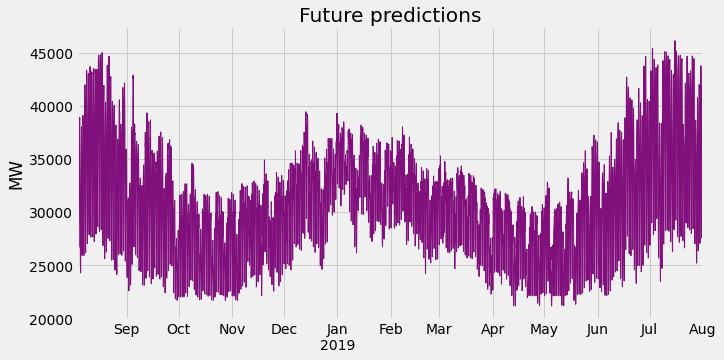

In [66]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'].plot(figsize=(10,5),
                              color=color_pal[5],
                              ms=1,
                              lw=1,
                              title='Future predictions')
plt.ylabel('MW')
plt.show;

In [ ]:
future_dates_max = pd.date_range(start='2018-08-03', end='2019-08-01', freq='H')
future_df = pd.DataFrame(index=future_dates)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)